
# Project Evaluation Analysis Notebook

## Imports





In [87]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
from collections import Counter
import string
import re
from difflib import SequenceMatcher

## Evaluating output NER Tagger

## Load NER output

In [40]:
# Load the correct JSON file
with open("braces_tagged_fine_batch.json", "r", encoding="utf-8") as f:
    data = json.load(f)

🔢 Total examples: 12636
✅ Examples with entity tags: 12636
❌ Examples without entity tags: 0

📊 Top 20 entity tags (excluding 'O'):
 I-Aktenzeichen: 73116
      B-Gericht: 24984
 B-Seite-Beginn: 19942
         B-Jahr: 16059
        I-Datum: 15617
 B-Aktenzeichen: 15171
    I-Paragraph: 14366
      I-Gericht: 11988
  B-Zeitschrift: 11831
    B-Paragraph: 4567
        B-Datum: 3971
       B-Gesetz: 3963
        B-Autor: 3583
       B-Nummer: 2325
   B-Randnummer: 2261
  I-Zeitschrift: 2179
B-Seite-Fundstelle: 1762
      B-Auflage: 1590
        I-Titel: 1422
   I-Randnummer: 1174


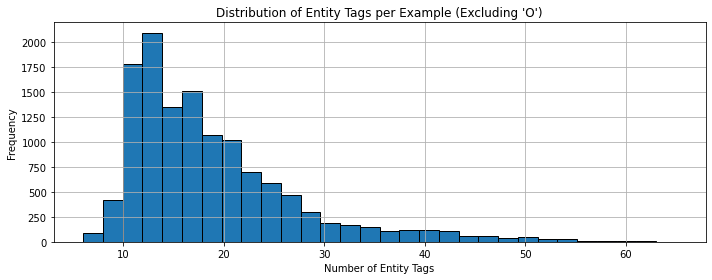

In [41]:
# Recalculate stats excluding 'O' tags
records = []
tag_counter = Counter()

for example in data:
    line_id = example.get("line_id")
    original_text = example.get("original_text", "")
    tagged_tokens = example.get("tagged_tokens", [])

    entity_tags = [tok["tag"] for tok in tagged_tokens if tok.get("tag") != "O"]
    tag_counter.update(entity_tags)

    records.append({
        "line_id": line_id,
        "original_text": original_text,
        "num_entity_tags": len(entity_tags)
    })

df = pd.DataFrame(records)

# Print sum
mary
print(f"Total examples: {len(df)}")
print(f"Examples with entity tags: {(df['num_entity_tags'] > 0).sum()}")
print(f"Examples without entity tags: {(df['num_entity_tags'] == 0).sum()}")

# Print top entity tags
print("\nTop 20 entity tags (excluding 'O'):")
for tag, count in tag_counter.most_common(20):
    print(f"{tag:>15}: {count}")

# Plot histogram
plt.figure(figsize=(10, 4))
df["num_entity_tags"].hist(bins=30, edgecolor="black")
plt.title("Distribution of Entity Tags per Example (Excluding 'O')")
plt.xlabel("Number of Entity Tags")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()


## Count "O" Tags in NER Output

In [42]:
total_tokens = 0
o_tokens = 0
o_meaningful = 0

for entry in data:
    for tok in entry.get("tagged_tokens", []):
        token = tok["token"]
        tag = tok["tag"]
        total_tokens += 1

        if tag == "O":
            o_tokens += 1
            # Only count it if it's a meaningful token (not punctuation)
            if token.isalnum() and token not in string.punctuation:
                o_meaningful += 1
print(f"Total tokens: {total_tokens}")
print(f"'O' tags (all): {o_tokens}")
print(f"'O' tags on words/numbers: {o_meaningful}")
print(f"Percentage of total that are 'O' on words: {round((o_meaningful / total_tokens) * 100, 2)}%")


🔢 Total tokens: 674309
❌ 'O' tags (all): 440081
⚠️  'O' tags on words/numbers: 141894
📉 Percentage of total that are 'O' on words: 21.04%


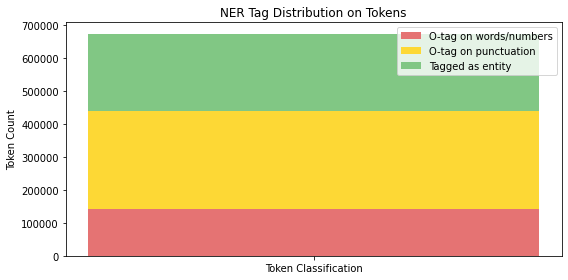

In [43]:

o_punctuation = o_tokens - o_meaningful
tagged_entities = total_tokens - o_tokens

labels = ["Token Classification"]
plt.figure(figsize=(8, 4))
plt.bar(labels, [o_meaningful], label="O-tag on words/numbers", color="#e57373")
plt.bar(labels, [o_punctuation], bottom=[o_meaningful], label="O-tag on punctuation", color="#fdd835")
plt.bar(labels, [tagged_entities], bottom=[o_meaningful + o_punctuation], label="Tagged as entity", color="#81c784")

plt.ylabel("Token Count")
plt.title("NER Tag Distribution on Tokens")
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()


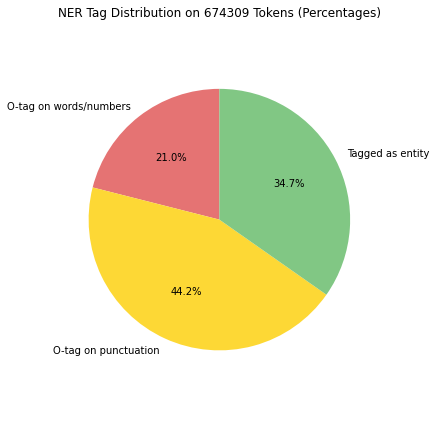

In [46]:
sizes = [o_meaningful, o_tokens - o_meaningful, total_tokens - o_tokens]
labels = [
    "O-tag on words/numbers",
    "O-tag on punctuation",
    "Tagged as entity"
]
colors = ["#e57373", "#fdd835", "#81c784"]

plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, colors=colors, autopct="%.1f%%", startangle=90)
plt.title("NER Tag Distribution on 674309 Tokens (Percentages)")
plt.axis("equal")  # Equal aspect ratio makes the pie round
plt.tight_layout()
plt.show()



## Evaluating/Load Data of T5 models (in numbers)


In [104]:
paths = {
    "T5BASE_10_epochs_ground_truth": "EVALUATION CSV/evaluation_results_T5BASE_10_epochs_on_ground_truth.csv",
    "T5BASE_10_epochs_clean": "EVALUATION CSV/evaluation_results_T5BASE_10_epochs_clean_data.csv",
    "T5BASE_5_epochs_clean": "EVALUATION CSV/evaluation_results_T5BASE_5_epochs_clean_data.csv",
    "T5BASE_5_epochs_raw": "EVALUATION CSV/evaluation_results_t5_base_v1.csv",
    "T5SMALL": "EVALUATION CSV/evaluation_results t5_small.csv"
}

dfs = {name: pd.read_csv(path) for name, path in paths.items()}



# Explanation:
# Some expected outputs in the data contain unwanted prefixes like file paths,
# "vgl.", or ECLI identifiers that are not generated by the model.
# These would unfairly lower the similarity score, so we clean them here.

url_pattern = r"^(?:\.\./[^ ]*|ECLI:[^ ]+|vgl\.|https?://\S+)\s*"

def clean_expected_output(text):
    if pd.isna(text):
        return ""
    return re.sub(url_pattern, "", text).strip()

for name in dfs:
    dfs[name]["expected_output"] = dfs[name]["expected_output"].apply(clean_expected_output)


## Visualization: Similarity Distribution

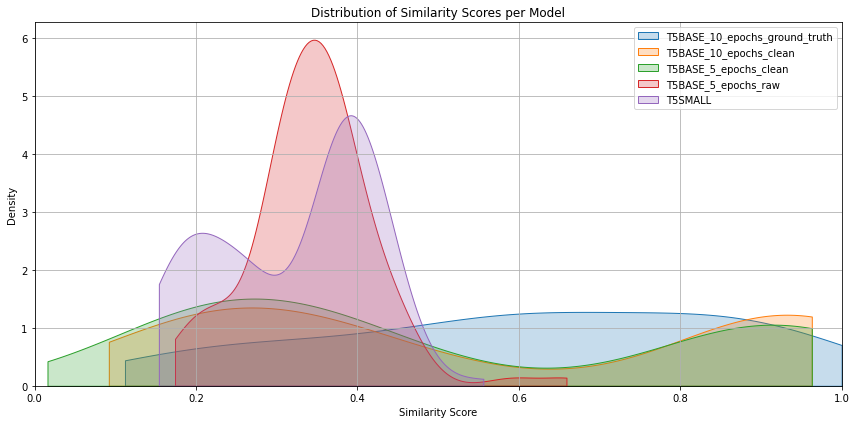

In [105]:
plt.figure(figsize=(12, 6))
for name, df in dfs.items():
    sns.kdeplot(df['similarity'], label=name, fill=True, cut=0)
plt.title("Distribution of Similarity Scores per Model")
plt.xlabel("Similarity Score")
plt.ylabel("Density")
plt.xlim(0, 1)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Summary Statistics

In [106]:
def summarize_evaluation_data(df):
    total = len(df)
    correct = df["match"].sum()
    avg_similarity = df["similarity"].mean()
    median_similarity = df["similarity"].median()
    min_similarity = df["similarity"].min()
    max_similarity = df["similarity"].max()

    return {
        "Total Samples": total,
        "Correct Predictions": correct,
        "Accuracy (%)": round((correct / total) * 100, 2),
        "Avg. Similarity": round(avg_similarity, 4),
        "Median Similarity": round(median_similarity, 4),
        "Min Similarity": round(min_similarity, 4),
        "Max Similarity": round(max_similarity, 4),
    }

summary_stats = {name: summarize_evaluation_data(df) for name, df in dfs.items()}
summary_df = pd.DataFrame(summary_stats).T
display(summary_df)

,Total Samples,Correct Predictions,Accuracy (%),Avg. Similarity,Median Similarity,Min Similarity,Max Similarity
T5BASE_10_epochs_ground_truth,49.0,1.0,2.04,0.6055,0.6250,0.112,1.000
T5BASE_10_epochs_clean,100.0,0.0,0.00,0.5555,0.4145,0.092,0.963
T5BASE_5_epochs_clean,100.0,0.0,0.00,0.5135,0.3770,0.016,0.963
T5BASE_5_epochs_raw,100.0,0.0,0.00,0.3436,0.3455,0.174,0.659
T5SMALL,100.0,0.0,0.00,0.3228,0.3630,0.154,0.556


In [107]:
# Filter to the single correct prediction from the real citation evaluation
correct_predictions_real = df_real[df_real["prediction"].str.strip() == df_real["original_text"].str.strip()]

# Show the matching row(s) to check if it's a true unique match or a duplicate
correct_predictions_real.reset_index(drop=True)


,line_id,original_text,input,prediction,similarity
0,L0015,Bl. 13 d. A.,Bl . 13 d . A .,Bl. 13 d. A.,1.0


In [108]:
# Examples with high similarity but failed match
for name, df in dfs.items():
    print(f"\n{name} - False Positives with High Similarity:")
    display(df[(df['match'] == 0) & (df['similarity'] > 0.75)].head(5))



T5BASE_10_epochs_ground_truth - False Positives with High Similarity:


,input,expected_output,predicted_output,match,similarity
0,§ 62 Abs . 5 BGB,§ 622 Abs. 5 BGB,626 Abs. 5 BGB,False,0.867
5,Az . : 10 Ca 103 / 03,Az.: 10h Ca 10381/03,Az.: 10 Ca 1038/03,False,0.947
12,"Baum / Lauter / Hartmann , 63 . Aufl . , § 136...","Baumbach/Lauterbach/Hartmann, 63. Aufl., § 136...","Baum/ Lauter/ Hartmann, 63. Aufl., 136 ZPO, R...",False,0.797
15,"AP - Dör , § 1 KSchG , Rz . 34 mit ausführlich...","APS-Dörner, § 1 KSchG, Rz. 343 mit ausführlich...","AP-Dörfler, 1 KSchG, Rz. 34 mit ausführlicher...",False,0.751
17,§ 61 a Abs . 1 Satz 1 BGB,§ 613 a Abs. 1 Satz 1 BGB,613 a Abs. 1 Satz 1 BGB,False,0.958



T5BASE_10_epochs_clean - False Positives with High Similarity:


,input,expected_output,predicted_output,match,similarity
1,court=OLG; year=2007; page_start=135; case_num...,§ 613a Abs. 1 Satz 1 TzBfG,613a Abs. 1 Satz 1 TzBfG,False,0.960
6,court=LAG; year=2002; page_start=609; case_num...,§ 41 Abs. 2 GG,41 Abs. 2 GG,False,0.923
7,court=FG; year=2020; page_start=165; case_numb...,§ 41 Abs. 2 BGB,41 Abs. 2 BGB,False,0.929
8,court=LAG; year=2006; page_start=479; case_num...,§ 622 Abs. 5 StGB,622 Abs. 5 StGB,False,0.938
9,court=VG; year=1991; page_start=440; case_numb...,§ 41 Abs. 2 GG,41 Abs. 2 GG,False,0.923



T5BASE_5_epochs_clean - False Positives with High Similarity:


,input,expected_output,predicted_output,match,similarity
1,court=OLG; year=2007; page_start=135; case_num...,§ 613a Abs. 1 Satz 1 TzBfG,613a Abs. 1 Satz 1 TzBfG,False,0.960
6,court=LAG; year=2002; page_start=609; case_num...,§ 41 Abs. 2 GG,vgl. 41 Abs. 2 GG,False,0.812
7,court=FG; year=2020; page_start=165; case_numb...,§ 41 Abs. 2 BGB,vgl. 41 Abs. 2 BGB,False,0.824
8,court=LAG; year=2006; page_start=479; case_num...,§ 622 Abs. 5 StGB,622 Abs. 5 StGB,False,0.938
9,court=VG; year=1991; page_start=440; case_numb...,§ 41 Abs. 2 GG,vgl. 41 Abs. 2 GG,False,0.812



T5BASE_5_epochs_raw - False Positives with High Similarity:


,input,expected_output,predicted_output,match,similarity



T5SMALL - False Positives with High Similarity:


,input,expected_output,predicted_output,match,similarity


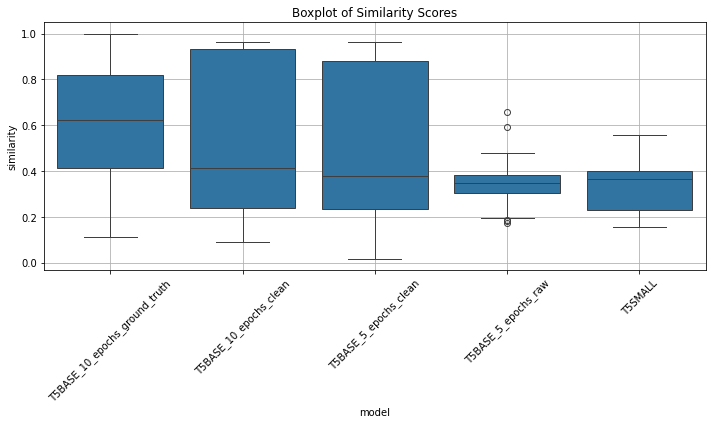

In [109]:
# Boxplot per model
plt.figure(figsize=(10, 6))
data = pd.concat([df.assign(model=name) for name, df in dfs.items()])
sns.boxplot(data=data, x="model", y="similarity")
plt.title("Boxplot of Similarity Scores")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


In [110]:
thresholds = [0.9,0.75, 0.5,0.25 ]
for name, df in dfs.items():
    print(f"\n{name} - Cumulative Accuracy by Similarity Threshold:")
    for t in thresholds:
        acc = (df["similarity"] >= t).mean()
        print(f"  ≥ {t}: {acc:.2%}")


T5BASE_10_epochs_ground_truth - Cumulative Accuracy by Similarity Threshold:
  ≥ 0.9: 12.24%
  ≥ 0.75: 36.73%
  ≥ 0.5: 67.35%
  ≥ 0.25: 87.76%

T5BASE_10_epochs_clean - Cumulative Accuracy by Similarity Threshold:
  ≥ 0.9: 36.00%
  ≥ 0.75: 42.00%
  ≥ 0.5: 45.00%
  ≥ 0.25: 72.00%

T5BASE_5_epochs_clean - Cumulative Accuracy by Similarity Threshold:
  ≥ 0.9: 25.00%
  ≥ 0.75: 37.00%
  ≥ 0.5: 38.00%
  ≥ 0.25: 70.00%

T5BASE_5_epochs_raw - Cumulative Accuracy by Similarity Threshold:
  ≥ 0.9: 0.00%
  ≥ 0.75: 0.00%
  ≥ 0.5: 2.00%
  ≥ 0.25: 88.00%

T5SMALL - Cumulative Accuracy by Similarity Threshold:
  ≥ 0.9: 0.00%
  ≥ 0.75: 0.00%
  ≥ 0.5: 1.00%
  ≥ 0.25: 71.00%


In [111]:
raw = dfs["T5BASE_5_epochs_raw"]
clean = dfs["T5BASE_5_epochs_clean"]
delta = clean["similarity"] - raw["similarity"]
print(f"Mean improvement after cleaning: {delta.mean():.4f}")


Mean improvement after cleaning: 0.1699


## Evaluation in words

In [113]:
# qualitative analysis for all models
for name, df in dfs.items():
    print(f"\n{name} — False Positives with High Similarity (≥ 0.9 and not exact match)")
    high_sim_false = df[(df["match"] == False) & (df["similarity"] >= 0.9)]
    display(high_sim_false[["input", "expected_output", "predicted_output", "similarity"]].head(5))

    print(f"{name} — Very Low Similarity Predictions (≤ 0.3)")
    low_sim = df[df["similarity"] <= 0.3]
    display(low_sim[["input", "expected_output", "predicted_output", "similarity"]].head(5))

    print(f"{name} — Most Common Predictions (Top 5)")
    display(df["predicted_output"].value_counts().head(5))

    print(f"{name} — Suspected Hallucinations (contains 'vgl', 'ECLI', or unrelated content)")
    hallucinations = df[df["predicted_output"].str.contains("vgl|ECLI|unified|gesp|Absatz", case=False, na=False)]
    display(hallucinations[["input", "expected_output", "predicted_output", "similarity"]].head(5))



T5BASE_10_epochs_ground_truth — False Positives with High Similarity (≥ 0.9 and not exact match)


,input,expected_output,predicted_output,similarity
5,Az . : 10 Ca 103 / 03,Az.: 10h Ca 10381/03,Az.: 10 Ca 1038/03,0.947
17,§ 61 a Abs . 1 Satz 1 BGB,§ 613 a Abs. 1 Satz 1 BGB,613 a Abs. 1 Satz 1 BGB,0.958
18,§ 61 a Abs . 1 Satz 2 BGB,§ 613 a Abs. 1 Satz 2 BGB,613 a Abs. 1 Satz 2 BGB,0.958
19,§ 61 a Abs . 1 Satz 3 BGB,§ 613 a Abs. 1 Satz 3 BGB,613 a Abs. 1 Satz 3 BGB,0.958
22,Bl . 26 d . A .,Bl. 264 d. A.,Bl. 26 d. A.,0.960


T5BASE_10_epochs_ground_truth — Very Low Similarity Predictions (≤ 0.3)


,input,expected_output,predicted_output,similarity
2,Parag 5 Abs . 1 B,Paragraph 5 Abs. 1 BUrlG,Parag 5 Abs. 1 B i.V.m. Parag 5 Abs. 1 B i.V.m...,0.154
7,vgl . BAG NJW 1971 S . 68,BAG NJW 1971 S. 689,vgl. BAG NJW 1971 S.68 vgl. vgl. BAG NJW 1971 ...,0.257
21,"AP - Back , § 14 Tz Rd . 73","APS-Backhaus, § 14 TzBfG Rdz. 73","AP-Back, 14 Tz Rd. 73 , AP-Arb., 14 Tz Rd. 7...",0.237
28,"AP - Dör , § 62 BGB , Rz . 35","APS-Dörner, § 626 BGB, Rz. 356","AP-Dörr, 626 BGB , Rz. 35 , Rz. 370 , AP-Dörr...",0.249
31,§ 1 Abs . 3 W,§ 1 Abs. 3 WBO,1 Abs. 3 W. 1 Abs. 3 W. 3 Abs. 3 W. 3 Abs. ...,0.112


T5BASE_10_epochs_ground_truth — Most Common Predictions (Top 5)


BAG NJW 2001 , Seite 209 , Seite 201 .                                                                                                                                                 2
626 Abs. 5 BGB                                                                                                                                                                         1
BAG NZA 1997 , Seite 47 , Seite 47 , Seite 47 .                                                                                                                                        1
AP-Dörr,  626 BGB , Rz. 35 , Rz. 370 , AP-Dörr,  626 BGB , Rz. 35 , Rz. 35 , Rz. 370 , Rz. 370 , Rz. 370 , Rz. 370 , Rz. 370 , Rz. 370 , Rz. 370 , Rz. 370 , Rz. 370 , Rz. 370 , Rz    1
17 Abs. 2 Satz 1 Nr. 1 SG i.V.m.  17 Abs. 1 Nr. 1 SG                                                                                                                                   1
Name: predicted_output, dtype: int64

T5BASE_10_epochs_ground_truth — Suspected Hallucinations (contains 'vgl', 'ECLI', or unrelated content)


,input,expected_output,predicted_output,similarity
3,"vgl . BAG AP Nr . 4 zu § 1 Besch 1996 , An / T...","BAG AP Nr. 4 zu § 1 BeschFG 1996, Anuß/Thüsing...","vgl. BAG AP Nr. 4 zu 1 Besch 1996 , An/Th , T...",0.530
6,vgl . BAG Urt . v . 24 . 01 . 2001 - Az . : 7 ...,BAG Urt. v. 24.01.2001 - Az.: 7 AZR 567/99 = F...,vgl. BAG Urt. v. 24.01.2001 - Az.: 7 AZR 567/9...,0.487
7,vgl . BAG NJW 1971 S . 68,BAG NJW 1971 S. 689,vgl. BAG NJW 1971 S.68 vgl. vgl. BAG NJW 1971 ...,0.257
20,vgl . BAG BB 1977 S . 120,BAG BB 1977 S. 1202,vgl. BAG BB 1977 S. 1202 vgl. vgl. BAG BB 1977...,0.565
43,"vgl . Ti in L - StGB , 11 . Aufl . , § 26 Rn ....","Tiedemann in LK-StGB, 11. Aufl., § 265b Rn. 29...","vgl. Ti in L- StGB , 11. Aufl., 26 Rn. 29 , W...",0.857



T5BASE_10_epochs_clean — False Positives with High Similarity (≥ 0.9 and not exact match)


,input,expected_output,predicted_output,similarity
1,court=OLG; year=2007; page_start=135; case_num...,§ 613a Abs. 1 Satz 1 TzBfG,613a Abs. 1 Satz 1 TzBfG,0.960
6,court=LAG; year=2002; page_start=609; case_num...,§ 41 Abs. 2 GG,41 Abs. 2 GG,0.923
7,court=FG; year=2020; page_start=165; case_numb...,§ 41 Abs. 2 BGB,41 Abs. 2 BGB,0.929
8,court=LAG; year=2006; page_start=479; case_num...,§ 622 Abs. 5 StGB,622 Abs. 5 StGB,0.938
9,court=VG; year=1991; page_start=440; case_numb...,§ 41 Abs. 2 GG,41 Abs. 2 GG,0.923


T5BASE_10_epochs_clean — Very Low Similarity Predictions (≤ 0.3)


,input,expected_output,predicted_output,similarity
0,court=FG; year=1995; page_start=479; case_numb...,§ 9 TzBfG,"vgl. FG Hamburg, Beschluss v. 03.11.1988, AL 4...",0.195
2,court=VG; year=1990; page_start=479; case_numb...,§ 9 ZPO,"vgl. VG Köln, Urteil vom 05.11.1989, AZR 101/2...",0.162
3,court=BGH; year=2005; page_start=930; case_num...,§ 9 StGB,"vgl. BGH, Urteil vom 05.03.1919, ZR 201/19, AP...",0.194
4,court=FG; year=1998; page_start=161; case_numb...,§ 9 TzBfG,"vgl. FG Hamburg, Urteil vom 05.03.1998, AL 45/...",0.208
5,court=SG; year=2004; page_start=30; case_numbe...,§ 134 StGB,"vgl. SG Köln, Urteil vom 09.11.1998, U 87/97, ...",0.231


T5BASE_10_epochs_clean — Most Common Predictions (Top 5)


613a Abs. 1 Satz 1 TzBfG      4
41 Abs. 2 GG                  4
622 Abs. 5 KSchG              3
613a Abs. 1 Satz 1 SGB III    2
613a Abs. 1 Satz 1 KSchG      2
Name: predicted_output, dtype: int64

T5BASE_10_epochs_clean — Suspected Hallucinations (contains 'vgl', 'ECLI', or unrelated content)


,input,expected_output,predicted_output,similarity
0,court=FG; year=1995; page_start=479; case_numb...,§ 9 TzBfG,"vgl. FG Hamburg, Beschluss v. 03.11.1988, AL 4...",0.195
2,court=VG; year=1990; page_start=479; case_numb...,§ 9 ZPO,"vgl. VG Köln, Urteil vom 05.11.1989, AZR 101/2...",0.162
3,court=BGH; year=2005; page_start=930; case_num...,§ 9 StGB,"vgl. BGH, Urteil vom 05.03.1919, ZR 201/19, AP...",0.194
4,court=FG; year=1998; page_start=161; case_numb...,§ 9 TzBfG,"vgl. FG Hamburg, Urteil vom 05.03.1998, AL 45/...",0.208
5,court=SG; year=2004; page_start=30; case_numbe...,§ 134 StGB,"vgl. SG Köln, Urteil vom 09.11.1998, U 87/97, ...",0.231



T5BASE_5_epochs_clean — False Positives with High Similarity (≥ 0.9 and not exact match)


,input,expected_output,predicted_output,similarity
1,court=OLG; year=2007; page_start=135; case_num...,§ 613a Abs. 1 Satz 1 TzBfG,613a Abs. 1 Satz 1 TzBfG,0.960
8,court=LAG; year=2006; page_start=479; case_num...,§ 622 Abs. 5 StGB,622 Abs. 5 StGB,0.938
11,court=OLG; year=1993; page_start=195; case_num...,§ 613a Abs. 1 Satz 1 KSchG,613a Abs. 1 Satz 1 KSchG,0.960
12,court=FG; year=2021; page_start=222; case_numb...,§ 613a Abs. 1 Satz 1 StGB,613a Abs. 1 Satz 1 StGB,0.958
18,court=OLG; year=1991; page_start=727; case_num...,§ 41 Abs. 2 SGB III,41 Abs. 2 SGB III,0.944


T5BASE_5_epochs_clean — Very Low Similarity Predictions (≤ 0.3)


,input,expected_output,predicted_output,similarity
0,court=FG; year=1995; page_start=479; case_numb...,§ 9 TzBfG,"vgl. FG Hamburg, Beschl. v. 05.11.1995, S. 12;...",0.016
2,court=VG; year=1990; page_start=479; case_numb...,§ 9 ZPO,"vgl. VG Köln, Beschl. v. 05.11.1989, AZR 101/2...",0.158
3,court=BGH; year=2005; page_start=930; case_num...,§ 9 StGB,"vgl. BGH, Beschl. v. 03.12.1999, ZR 201/19, Rn...",0.203
4,court=FG; year=1998; page_start=161; case_numb...,§ 9 TzBfG,"vgl. FG Hamburg, Beschl. v. 05.11.1998, S. 12;...",0.104
5,court=SG; year=2004; page_start=30; case_numbe...,§ 134 StGB,"vgl. SG, Urteil vom 05.03.1997, U. 87/97, 134...",0.261


T5BASE_5_epochs_clean — Most Common Predictions (Top 5)


613a Abs. 1 Satz 1 TzBfG      4
vgl.  41 Abs. 2 GG            3
613a Abs. 1 Satz 1 ZPO        2
613a Abs. 1 Satz 1 SGB III    2
vgl.  622 Abs. 5 GG           2
Name: predicted_output, dtype: int64

T5BASE_5_epochs_clean — Suspected Hallucinations (contains 'vgl', 'ECLI', or unrelated content)


,input,expected_output,predicted_output,similarity
0,court=FG; year=1995; page_start=479; case_numb...,§ 9 TzBfG,"vgl. FG Hamburg, Beschl. v. 05.11.1995, S. 12;...",0.016
2,court=VG; year=1990; page_start=479; case_numb...,§ 9 ZPO,"vgl. VG Köln, Beschl. v. 05.11.1989, AZR 101/2...",0.158
3,court=BGH; year=2005; page_start=930; case_num...,§ 9 StGB,"vgl. BGH, Beschl. v. 03.12.1999, ZR 201/19, Rn...",0.203
4,court=FG; year=1998; page_start=161; case_numb...,§ 9 TzBfG,"vgl. FG Hamburg, Beschl. v. 05.11.1998, S. 12;...",0.104
5,court=SG; year=2004; page_start=30; case_numbe...,§ 134 StGB,"vgl. SG, Urteil vom 05.03.1997, U. 87/97, 134...",0.261



T5BASE_5_epochs_raw — False Positives with High Similarity (≥ 0.9 and not exact match)


,input,expected_output,predicted_output,similarity


T5BASE_5_epochs_raw — Very Low Similarity Predictions (≤ 0.3)


,input,expected_output,predicted_output,similarity
1,court=VG; year=2011; page_start=01; case_numbe...,"VG, 2011, Seite 01, Az.: 3 Ca 4567/21, § 41 Ab...",../../gesp-experiments/unified-gesp-dataset/Br...,0.292
16,court=AG; year=2012; page_start=39; case_numbe...,"AG, 2012, Seite 39, Az.: 3 Ca 4567/21, § 134, BGB",../../gesp-experiments/unified-gesp-dataset/Br...,0.230
20,court=OVG; year=2009; page_start=72; case_numb...,"OVG, 2009, Seite 72, Az.: S 12 AL 45/18, § 134...",../../gesp-experiments/unified-gesp-dataset/Br...,0.294
21,court=VG; year=2006; page_start=34; case_numbe...,"VG, 2006, Seite 34, Az.: 3 Ca 4567/21, § 134, ...",../../gesp-experiments/unified-gesp-dataset/Br...,0.244
22,court=LG; year=2007; page_start=97; case_numbe...,"LG, 2007, Seite 97, Az.: 3 Ca 4567/21, § 242, GG",../../gesp-experiments/unified-gesp-dataset/Br...,0.224


T5BASE_5_epochs_raw — Most Common Predictions (Top 5)


41 Abs. 2 GG                                                                                                                         3
622 Abs. 5 BGB                                                                                                                       2
../../gesp-experiments/unified-gesp-dataset/Bremen/FGHB/ECLI:DE:FGHB:2023:0809.3K73.12.1K227.067.21.txt  41 Abs. 2 KSchG             1
../../gesp-experiments/unified-gesp-dataset/Bremen/FGHB/ECLI:DE:FGHB:2023:691 BvR 123/20 , AP Nr. 58 zu  242 KSchG                   1
../../gesp-experiments/unified-gesp-dataset/Bremen/OLGHB/ECLI:DE:OLGHB:2000:2109.3U26.Ca.4567/21.12.19.txt vgl. auch  134 SGB III    1
Name: predicted_output, dtype: int64

T5BASE_5_epochs_raw — Suspected Hallucinations (contains 'vgl', 'ECLI', or unrelated content)


,input,expected_output,predicted_output,similarity
0,court=BGH; year=2007; page_start=99; case_numb...,"BGH, 2007, Seite 99, Az.: 2 StR 567/19, § 242,...",../../gesp-experiments/unified-gesp-dataset/Br...,0.407
1,court=VG; year=2011; page_start=01; case_numbe...,"VG, 2011, Seite 01, Az.: 3 Ca 4567/21, § 41 Ab...",../../gesp-experiments/unified-gesp-dataset/Br...,0.292
2,court=AG; year=2007; page_start=75; case_numbe...,"AG, 2007, Seite 75, Az.: S 12 AL 45/18, § 242,...",../../gesp-experiments/unified-gesp-dataset/Br...,0.313
3,court=VG; year=2014; page_start=47; case_numbe...,"VG, 2014, Seite 47, Az.: 1 BvR 123/20, § 242, ...",../../gesp-experiments/unified-gesp-dataset/Br...,0.364
4,court=VG; year=2010; page_start=53; case_numbe...,"VG, 2010, Seite 53, Az.: 1 BvR 123/20, § 622 A...",vgl. BvR 123/20 622 Abs. 5 KSchG,0.659



T5SMALL — False Positives with High Similarity (≥ 0.9 and not exact match)


,input,expected_output,predicted_output,similarity


T5SMALL — Very Low Similarity Predictions (≤ 0.3)


,input,expected_output,predicted_output,similarity
0,court=BGH; year=2007; page_start=99; case_numb...,"BGH, 2007, Seite 99, Az.: 2 StR 567/19, § 242,...",../../gesp-experiments/unified-gesp-dataset/Br...,0.220
2,court=AG; year=2007; page_start=75; case_numbe...,"AG, 2007, Seite 75, Az.: S 12 AL 45/18, § 242,...",../../gesp-experiments/unified-gesp-dataset/Br...,0.276
10,court=OVG; year=2010; page_start=19; case_numb...,"OVG, 2010, Seite 19, Az.: 3 Ca 4567/21, § 242, GG",../../gesp-experiments/unified-gesp-dataset/Br...,0.240
11,court=OVG; year=2020; page_start=88; case_numb...,"OVG, 2020, Seite 88, Az.: 2 StR 567/19, § 134,...",../../gesp-experiments/unified-gesp-dataset/Br...,0.273
16,court=AG; year=2012; page_start=39; case_numbe...,"AG, 2012, Seite 39, Az.: 3 Ca 4567/21, § 134, BGB",../../gesp-experiments/unified-gesp-dataset/Br...,0.154


T5SMALL — Most Common Predictions (Top 5)


41 Abs. 2 KSchG      9
622 Abs. 5 BGB       6
41 Abs. 2 BGB        6
622 Abs. 5 GG        5
41 Abs. 2 SGB III    5
Name: predicted_output, dtype: int64

T5SMALL — Suspected Hallucinations (contains 'vgl', 'ECLI', or unrelated content)


,input,expected_output,predicted_output,similarity
0,court=BGH; year=2007; page_start=99; case_numb...,"BGH, 2007, Seite 99, Az.: 2 StR 567/19, § 242,...",../../gesp-experiments/unified-gesp-dataset/Br...,0.220
2,court=AG; year=2007; page_start=75; case_numbe...,"AG, 2007, Seite 75, Az.: S 12 AL 45/18, § 242,...",../../gesp-experiments/unified-gesp-dataset/Br...,0.276
3,court=VG; year=2014; page_start=47; case_numbe...,"VG, 2014, Seite 47, Az.: 1 BvR 123/20, § 242, ...",../../gesp-experiments/unified-gesp-dataset/Br...,0.382
9,court=LG; year=2009; page_start=89; case_numbe...,"LG, 2009, Seite 89, Az.: 1 BvR 123/20, § 134, ...",../../gesp-experiments/unified-gesp-dataset/Br...,0.370
10,court=OVG; year=2010; page_start=19; case_numb...,"OVG, 2010, Seite 19, Az.: 3 Ca 4567/21, § 242, GG",../../gesp-experiments/unified-gesp-dataset/Br...,0.240
